# Segmentação de painéis solares utilizando imagens de satélite
---
# Solar Panel Segmentation Using Satellite Imagery

This script is used to prepare the dataset for machine learning algorithms.

## **Libraries and Imports**

In [1]:
from google.colab import drive
import os

import pandas as pd
import numpy as np
import math

import json
import random
import zipfile
from tabulate import tabulate

from PIL import Image
import sklearn
from sklearn.model_selection import train_test_split
import itertools
import copy

import io
import skimage.io
from skimage.measure import label

import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/gdrive')

raw_data_dir =     "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/raw/bdappv.zip"
interim_data_dir = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/"
assets_data_dir =  "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/assets/"

db = 'google'
mask_zip_dir = f'bdappv/{db}/mask'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
random.seed(42)

proportions =[[0.7, 0.3], [0.8, 0.2], [0.9, 0.1]]
filename_proportion=['7030', '8020', '9010']

google_masked_size = 1              # Usar todo o conjunto google_masked
ign_masked_size    = 1              # Usar todo o conjunto google_masked

train_and_validation_set_size = 0.8
train_set_size = 0.75                 #   == 0.75*0.8*set_size = 0.6*set_size

## **Functions**

In [ ]:
#______________________________________________________________________________#
#  Function to get a list of all imgs or masks in zipped google or ign bases
#______________________________________________________________________________#

def list_zipped_files(raw_data_dir, zip_folder_path):

    """
    raw_data_dir (str): A string that represents the directory where the raw
    data files are located.

    zip_folder_path (str): A string that represents the directory where imgs or
    masks are located inside zip file.

    Returns a list with all the file names from a directory on the drive.
    """

    with zipfile.ZipFile(raw_data_dir, 'r') as zip_file:

        listed_files_and_folders = zip_file.namelist();
        files_in_folder = [i for i in listed_files_and_folders if i.startswith(zip_folder_path)];
        del files_in_folder[0];

    return files_in_folder

#______________________________________________________________________________#
#  Function to get a dictionary of all imgs or masks in google or ign bases
#______________________________________________________________________________#

def get_raw_dictionary(raw_data_dir, zip_folder_path, category):

    """
    raw_data_dir (str): A string that represents the directory where the raw
    data files are located.

    zip_folder_path (str): A string that represents the directory where imgs or
    masks are located inside zip file.

    category: A string to categorize the dictionary files into one class.

    Returns a dictionary with all the file names from a directory on the drive.
    """

    files_in_folder = list_zipped_files(raw_data_dir, zip_folder_path)
    dictionary = dict.fromkeys([category],files_in_folder)
    #dictionary = {category: tuple(files_in_folder)}

    return dictionary

#______________________________________________________________________________#
#  Function to categorize the dataset
#______________________________________________________________________________#

def categorize_data(google_img_dictionary, ign_img_dictionary, google_mask_dictionary, ign_mask_dictionary):
    """
    Args:
      google_img_dictionary: Dictionary of images captured from the Google database;

      ign_img_dictionary: Dictionary of images captured from the IGN database;

      google_mask_dictionary: Dictionary of masks associated with the Google images;

      ign_mask_dictionary: Dictionary of masks associated with the IGN images;

    Returns:
      two category dictionaries with the occurrence count of 'masked' and
      'unmasked' in the Google and IGN databases. It also returns two dictionaries,
      google_data and ign_data, that store the categories for each image in their
      respective databases.
    """

    google_categories = {'masked': 0, 'unmasked': 0}
    ign_categories = {'masked': 0, 'unmasked': 0}

    google_data = {}
    ign_data = {}

    google_img_dictionary = list(google_img_dictionary.values())[0]
    ign_img_dictionary = list(ign_img_dictionary.values())[0]
    google_mask_dictionary = list(google_mask_dictionary.values())[0]
    ign_mask_dictionary = list(ign_mask_dictionary.values())[0]

    for img in google_img_dictionary:
        if img.split('/')[-1] in [mask.split('/')[-1] for mask in google_mask_dictionary]:
            google_data[img] = 'masked'
            google_categories['masked'] += 1
        else:
            google_data[img] = 'unmasked'
            google_categories['unmasked'] += 1

    for img in ign_img_dictionary:
        if img.split('/')[-1] in [mask.split('/')[-1] for mask in ign_mask_dictionary]:
            ign_data[img] = 'masked'
            ign_categories['masked'] += 1
        else:
            ign_data[img] = 'unmasked'
            ign_categories['unmasked'] += 1

    return google_categories, ign_categories, google_data, ign_data

#______________________________________________________________________________#
#  Function to select images based on uniformity criterion
#______________________________________________________________________________#

def threshold_dictionary(raw_data_dir, zip_folder_path, threshold=0.95):
    """
    raw_data_dir: Root directory of the raw data.
    zip_folder_path: Path to the compressed folder containing the images.
    threshold: Threshold for the percentage of pixels with the same value.

    Returns a dictionary containing the paths of the images that meet the selection criteria.
    """

    results = {}
    files_in_folder = list_zipped_files(raw_data_dir, zip_folder_path)

    with zipfile.ZipFile(raw_data_dir, 'r') as zip_file:
        for file_path in files_in_folder:
            img_file=[];
            img_file = zip_file.open(file_path)
            img = Image.open(img_file)
            img = img.resize((32, 32))
            img_np = np.array(img)
            counts = np.bincount(img_np.ravel())
            max_val = np.argmax(counts)
            count_max = counts[max_val]

            if (count_max / img_np.size) >= threshold:
                results[file_path] = True

            else:
                results[file_path] = False

    return results

#______________________________________________________________________________#
#  Function to filter data with glitched imgs
#______________________________________________________________________________#

def filter_dictionary(dictionary, value = True):
    """
    dictionary: Input data, dictionary of values with and without masks
    (google_data or ign_data).

    value: Desired rule (True shows glitched imgs, False show valid imgs).

    Returns a dictionary with all valid or invalid imgs
    """

    filtered_dictionary = [key for key, val in dictionary.items() if val == value]

    return filtered_dictionary

#______________________________________________________________________________#
#  Function to clear the dictionary
#______________________________________________________________________________#

def clean_dictionary(dictionary_raw, list_invalid):
    """
    dictionary: Dictionary with the list of images.

    ter: Vector with all the terms to be removed.

    Returns a dictionary containing only the terms that are not present in the
    vector.
    """

    for term in list_invalid:
        if term in dictionary_raw:
            del dictionary_raw[term]

    dictionary_cleaned = dictionary_raw

    return dictionary_cleaned

#______________________________________________________________________________#
#  Function to create an empty mask for images without segmentation masks
#______________________________________________________________________________#

def create_mask(zip_folder_path, mask_folder_path, folder_path_to_save_mask, file_extension='.png'):
    """
    Args:
        zip_folder_path (str): File path to the zipped folder of the database.
        mask_folder_path (str): File path 'inside' the zipped folder to the masks of the dataset.
        folder_to_save_mask (str): File path to the destiny of the created mask
        file_extension (str): Extension of the masks file, default '.png'
    """
    file_name = ''

    with zipfile.ZipFile(zip_folder_path, 'r') as zip_ref:
        for name in zip_ref.namelist():
            if name.startswith(mask_folder_path) and name.endswith(file_extension):
                # print(name)
                zip_ref.extract(name)
                # print('extract')
                file_name = name.split('/')[-1]
                # print(file_name)
                break
    image = Image.open(mask_folder_path + '/' + file_name)
    # image.show()

    black_mask = Image.new("L", image.size, 0)
    # black_mask.show()

    black_mask.save(folder_path_to_save_mask)

    return

#______________________________________________________________________________#
# Function to count instances of Solar panels in masks
#______________________________________________________________________________#

def count_objects_in_zip(zip_file_path, file_list):
    """
    zip_file_path (str): A string that represents the directory where the raw
    data files are located.

    file_list: A list with all paths + masks file name.

    Returns a dictionary containing the count of panels in each mask.
    """
    dictionary = {}
    table_results = {}

    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        for file_name in file_list:
            # Load binary image from the zip
            with zip_file.open(file_name) as file:
                image_data = io.BytesIO(file.read())
                image = skimage.io.imread(image_data, as_gray=True)
            labeled_image = label(image)
            num_objects = labeled_image.max()
            table_results[file_name] = num_objects
            if num_objects in dictionary:
                dictionary[num_objects].append(file_name)
            else:
                dictionary[num_objects] = [file_name]

    return dictionary,table_results

#______________________________________________________________________________#
# Function to create stratified train, test, and validation sets as a list
#______________________________________________________________________________#

def define_stratified_masked_set(dictionary_with_classes,train_and_validation_set_size,train_set_size,imgs_folder_path='bdappv/google/img/',masks_folder_path='bdappv/google/mask/',random_seed=42,):
    """
    dictionary_with_classes: A dictionary in the format {Path: class, Path1: class1, ...} containing the classes for each file.
    train_and_validation_set_size: Desired size for the training and validation set.
    train_set_size: Desired size for the training set.
    imgs_folder_path: Path to the folder where the images are located.
    masks_folder_path: Path to the folder where the masks are located.
    random_seed: Random seed for ensuring reproducibility.

    Returns a series of lists containing file paths and classes for each dataset.
    """

    imgs = [s.split('/')[-1] for s in list(dictionary_with_classes.keys())]
    classes = list(dictionary_with_classes.values())

    new_classes = []
    for s in classes:
        if s >= 5:
            new_classes.append("5+")
        else:
            new_classes.append(s)

    imgs_train_val, imgs_test, classes_train_val, classes_test = sklearn.model_selection.train_test_split(imgs, new_classes,  train_size=train_and_validation_set_size, stratify=new_classes, random_state=random_seed)
    imgs_train, imgs_val, classes_train, classes_val = sklearn.model_selection.train_test_split(imgs_train_val, classes_train_val, train_size=train_set_size, stratify=classes_train_val, random_state=random_seed)

    train_masked_path = imgs_train.copy(); train_masked_path = [imgs_folder_path + s for s in train_masked_path];
    train_masks_path = imgs_train.copy(); train_masks_path = [masks_folder_path + s for s in train_masks_path];

    val_masked_path = imgs_val.copy(); val_masked_path= [imgs_folder_path + s for s in val_masked_path];
    val_masks_path = imgs_val.copy(); val_masks_path = [masks_folder_path + s for s in val_masks_path];

    test_masked_path = imgs_test.copy();test_masked_path = [imgs_folder_path + s for s in test_masked_path];
    test_masks_path = imgs_test.copy(); test_masks_path = [masks_folder_path + s for s in test_masks_path];

    train_with_classes = transform_dictionary(dict(zip(train_masks_path, classes_train)));
    val_with_classes = transform_dictionary(dict(zip(train_masks_path, classes_val)));
    test_with_classes = transform_dictionary(dict(zip(train_masks_path, classes_test)));

    return train_masked_path, train_masks_path, classes_train, val_masked_path, val_masks_path, classes_val, test_masked_path, test_masks_path, classes_test, train_with_classes, val_with_classes, test_with_classes

def transform_dictionary(dictionary_with_classes):
    """
    dictionary_with_classes: A dictionary in the format {Path: class, Path1: class1, ...} containing the classes for each file.

    Return a new dictionary in in the format {Class: [list of all paths]...}
    """
    transformed_dict = {}
    for path, classe in dictionary_with_classes.items():
        if classe not in transformed_dict:
            transformed_dict[classe] = []
        transformed_dict[classe].append(path)

    return transformed_dict

#______________________________________________________________________________#
#  Function to create graphs for each data split for training the CNN
#______________________________________________________________________________#

def create_graphs(dict_folder_path, file_name, file_extension, proportions, folder_to_save_graphs):
    """
    Args:
        dict_folder_path (str): File path to the dictionary containing the splits for the CNN.
        file_name (str): Name of the file with the output dict.
        file_extension (str): Extension of the file with the output dict.
        Proportions (List: str): Pre-defined proportions for the splits.
        folder_to_save_graphs (str): File path to the folder with the assets of the project
    """
    cmap = plt.colormaps["tab20c"]
    outer_colors = cmap(np.arange(3)*4)
    inner_colors = cmap([1, 2, 5, 6, 9, 10])

    outer_labels = 'Train', 'Validation', 'Test'
    inner_labels = 'Masked', 'Unmasked','Masked', 'Unmasked','Masked', 'Unmasked'

    plt.figure(figsize=(12,6))

    for idx, proportion in enumerate(proportions):
      # print(proportion)
      output_path = f"{dict_folder_path}{file_name}{proportion}{file_extension}"

      with open(output_path, 'r') as f:
        output_dict = json.load(f)

      output_list = [
          [len(output_dict['train']['masked'][0]),      len(output_dict['train']['unmasked'][0])],
          [len(output_dict['validation']['masked'][0]), len(output_dict['validation']['unmasked'][0])],
          [len(output_dict['test']['masked'][0]),       len(output_dict['test']['unmasked'][0])],
      ]

      # print(output_list)

      plt.subplot(int((1*100) + (len(proportions)*10)+(idx+1)))

      size = 0.3
      vals = np.array(output_list)

      # outer slices
      plt.pie(vals.sum(axis=1), radius=1, colors=outer_colors,
            wedgeprops=dict(width=size, edgecolor='w'), labeldistance=1.15, labels=outer_labels, autopct='%1.1f%%', pctdistance=0.85)

      # inner slices
      plt.pie(vals.flatten(), radius=1-size, colors=inner_colors,
            wedgeprops=dict(width=size, edgecolor='w'))

      plt.gca().set_title(f'Masked: {proportion[:2]} %\nUnmasked: {proportion[-2:]} %', size=10)

      vals = np.c_[ vals, np.transpose(np.array([vals[0][0] + vals[0][1],vals[1][0] + vals[1][1], vals[2][0] + vals[2][1] ])) ]
      vals = np.r_[vals, [np.sum(vals, axis=0)]]
      # print(vals)
      df = pd.DataFrame(vals, columns=[ 'Masked', 'Unmasked', 'Total'], index=['Train', 'Val', 'Test', 'Total'])
      # display(df)

      props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
      textstr = df.to_string(col_space=5)

      # place a text box in upper left in axes coords
      plt.text(-0.8, -1.5, textstr,  fontsize=8,
              verticalalignment='top', bbox=props)

    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=1,
                        top=0.9,
                        wspace=0.4,
                        hspace=0.4)

    plt.legend(loc=(1.2, 0), labels=outer_labels+inner_labels)
    # plt.show()
    plt.savefig(folder_to_save_graphs+'splits.svg', bbox_inches='tight')

    return

#______________________________________________________________________________#
#  Function to list directories and files in the database
#______________________________________________________________________________#

def list_files_in_zip(zip_file_path, db_name):
    """
    Args:
        zip_file_path (str): File path to the zipped dataset.
        db_name (str): zipped dataset name

    Return a two dictionaries, one with files in the db, another one with paths.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        files_and_dirs = set()
        parent_dirs = set()
        aux = 0

        for file_info in zip_ref.infolist():
            # Extract file/directory name from file path
            name = file_info.filename

            # Verify if the name is not a path
            if not name.endswith('/'):

              # Check the directory
              directory = name.rsplit('/', 1)[0]+'/'

              # Check if the directory is already in parent_dirs, or if it is a file in
              if (directory in parent_dirs and aux == 1) or directory == db_name:
                files_and_dirs.add(name)
                aux = 0

            # If it is a path, saves in parent_dirs set
            else:
              parent_dirs.add(name)
              aux = 1
    return sorted(files_and_dirs), sorted(parent_dirs)

#______________________________________________________________________________#
#  Function to save a string as an image
#______________________________________________________________________________#
def create_string_image(string, image_path, image_name):
    """
    Args:
        string (str): string to be printed in an image
        image_path (str): path to save image
        image_name (str): image name
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Remove the axis
    ax.axis('off')

    # Set the text properties
    ax.text(0.5, 0.5, string, fontsize=24, ha='left', va='top')

    # Save the figure as an image
    plt.savefig(image_path + image_name, bbox_inches='tight', pad_inches=0)

    # Close the figure
    plt.close(fig)
    return

#______________________________________________________________________________#
#  Function to save a dataframe or series as an image
#______________________________________________________________________________#
def create_df_image(df, image_path, image_name):
    """
    Args:
        string (str): string to be printed in an image
        image_path (str): path to save image
        image_name (str): image name
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Remove the axis
    ax.axis('off')

    # col_widths = [max(len(str(value)) for value in df[column]) for column in df.columns]
    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='left')
    table.auto_set_font_size(False)
    table.auto_set_column_width(col=list(range(len(df.columns))))
    table.set_fontsize(12)
    table.scale(1, 1.5)

    # table.scale(1.2, 1.2)
    # pd.plotting.table(ax, df)

    # Set the text properties
    # ax.text(0.5, 0.5, string, fontsize=24, ha='left', va='top')

    # Save the figure as an image
    plt.savefig(image_path + image_name, bbox_inches='tight')
    # plt.show()

    # Close the figure
    plt.close(fig)
    return

#______________________________________________________________________________#
#  Function to create the directory tree fot the database and save as an image
#______________________________________________________________________________#
def generate_dir_tree(paths, files, image_path, image_name):
    """
    Args:
        paths (dict[str]): dictionary with the paths in the main folder of the dataset
        files (dict[str]): dictionary with the files inside the paths and in the main folder of the dataset
        img_path (str): path to save image
        img_name (str): image name

    Return a two dictionaries, one with files in the db, another one with paths.
    """

    directory_tree = {}

    for path in paths:
        directories = path.strip('/').split('/')
        current_directory = directory_tree

        for directory in directories:
            if directory not in current_directory:
                current_directory[directory] = {}
            current_directory = current_directory[directory]

    for file in files:
        file_path = file.strip('/').split('/')
        current_directory = directory_tree

        for directory in file_path[:-1]:
            if directory not in current_directory:
                current_directory[directory] = {}
            current_directory = current_directory[directory]

        current_directory[file_path[-1]] = None

    def print_directory_tree(directory, indent='', output=''):
        for name, content in directory.items():
            if isinstance(content, dict):
                output += f"{indent}|-- {name}\n"
                output = print_directory_tree(content, indent + "|   ", output)
            else:
                output += f"{indent}|-- {name}\n"
        return output

    # Generate the directory tree as a string
    directory_tree_string = print_directory_tree(directory_tree)

    # Print the directory tree
    create_string_image(directory_tree_string, assets_data_dir, image_name)
    print(directory_tree_string)
    return

## **DB directory tree and files evaluation**

In [ ]:
db_name = 'bdappv/'
db_files, db_paths = list_files_in_zip(raw_data_dir, db_name)

# Creates the directory tree and saves as an image
generate_dir_tree(db_paths, db_files, assets_data_dir, 'directory_tree.svg')

|-- bdappv
|   |-- google
|   |   |-- img
|   |   |   |-- AAAMMB2EPPRCL.png
|   |   |-- mask
|   |   |   |-- AABCN78E1YHCWW.png
|   |-- ign
|   |   |-- img
|   |   |   |-- AAAMMB2EPPRCL.png
|   |   |-- mask
|   |   |   |-- AABCN78E1YHCWW.png
|   |-- metadata.csv



In [ ]:
db_files_report = {
    'file': list(db_files),
    'extension': [],
    'image': [],
    'size': [],
    'dim': [],
    'mode': [],
    'limits': [],
}
# 'obs': [],

for file in db_files:
  extension = file.rsplit('.', 1)[1]
  db_files_report['extension'].append(extension)

  if extension == 'png':
     db_files_report['image'].append(True)
     with zipfile.ZipFile(raw_data_dir, 'r') as zip_file:
        # Read the image file as bytes from the zip file
        with zip_file.open(file) as image_file:
            # Create a BytesIO object and load the image
            image_data = io.BytesIO(image_file.read())
            image = Image.open(image_data)

            db_files_report['size'].append((image.size))
            db_files_report['dim'].append(len(image.mode))
            db_files_report['mode'].append(image.mode)
            db_files_report['limits'].append(image.getextrema())
            # db_files_report['obs'].append('')

  elif extension == 'csv':
    db_files_report['image'].append(False)

    with zipfile.ZipFile(raw_data_dir, 'r') as zip_file:
        # Read the image file as bytes from the zip file

        with zip_file.open(file) as csv_file:
          df = pd.read_csv(csv_file)
          headers = df.columns.tolist()

          db_files_report['size'].append((df.shape[0], df.shape[1]))
          db_files_report['dim'].append(1)
          db_files_report['mode'].append(False)
          db_files_report['limits'].append(False)
          # db_files_report['obs'].append(headers)

df = pd.DataFrame.from_dict(db_files_report)
df.columns = df.columns.str.capitalize()
display(df)

create_df_image(df, assets_data_dir, 'content_data.svg')

,File,Extension,Image,Size,Dim,Mode,Limits
0,bdappv/google/img/AAAMMB2EPPRCL.png,png,True,"(400, 400)",1,P,"(0, 252)"
1,bdappv/google/mask/AABCN78E1YHCWW.png,png,True,"(400, 400)",1,L,"(0, 255)"
2,bdappv/ign/img/AAAMMB2EPPRCL.png,png,True,"(400, 400)",4,RGBA,"((39, 254), (47, 255), (30, 255), (255, 255))"
3,bdappv/ign/mask/AABCN78E1YHCWW.png,png,True,"(400, 400)",1,L,"(0, 255)"
4,bdappv/metadata.csv,csv,False,"(28408, 21)",1,False,False


## **Spurious Data Identification and Removal**

In [ ]:
# Obtains dictionaries of raw image and mask data for Google and IGN.
google_imgs = get_raw_dictionary(raw_data_dir, 'bdappv/google/img/','img')
google_masks = get_raw_dictionary(raw_data_dir, 'bdappv/google/mask/','mask')
ign_imgs = get_raw_dictionary(raw_data_dir, 'bdappv/ign/img/','img')
ign_masks = get_raw_dictionary(raw_data_dir, 'bdappv/ign/mask/','mask')

In [ ]:
# Categorizes the data of Google and IGN images and masks into categories. This cell takes aproximatelly 3 minutes to run.
google_categories, ign_categories, google_data, ign_data = categorize_data(google_imgs, ign_imgs, google_masks, ign_masks)

In [ ]:
print('Images in the database obtained with Google: ',google_categories);
print('Images in the database obtained with IGN: ',ign_categories);

Images in the database obtained with Google:  {'masked': 13303, 'unmasked': 15504}
Images in the database obtained with IGN:  {'masked': 7685, 'unmasked': 9640}


In [ ]:
# Applies a threshold to the dictionary of Google and IGN images. Images classified as True are errors. This cell takes aproximatelly 6 minutes to run.
google_threshold = threshold_dictionary(raw_data_dir, 'bdappv/google/img/', threshold=0.9)
ign_threshold = threshold_dictionary(raw_data_dir, 'bdappv/ign/img/', threshold=0.9)

In [ ]:
# Create a list of all erroneous images.
google_invalid_imgs_list = filter_dictionary(google_threshold)
ign_invalid_imgs_list = filter_dictionary(ign_threshold)

print('Glitched images in the database obtained with Google: ',len(google_invalid_imgs_list));
print('Glitched images in the database obtained with IGN: ',len(ign_invalid_imgs_list));

Glitched images in the database obtained with Google:  176
Glitched images in the database obtained with IGN:  96


In [ ]:
# Clean the raw dictionaries based on the list of invalid images.
cleaned_google_data = clean_dictionary(google_data, google_invalid_imgs_list)
cleaned_ign_data = clean_dictionary(ign_data, ign_invalid_imgs_list)

In [ ]:
# Separates the sets of valid images into masked and unmasked.
cleaned_google_masked_list = filter_dictionary(cleaned_google_data, 'masked')
cleaned_google_unmasked_list = filter_dictionary(cleaned_google_data, 'unmasked')
cleaned_ign_masked_list = filter_dictionary(cleaned_ign_data, 'masked')
cleaned_ign_unmasked_list = filter_dictionary(cleaned_ign_data, 'unmasked')

## **DB Statistics**

In [ ]:
data = [
    ['Google total valid imgs with mask', len(cleaned_google_masked_list)],
    ['Google total valid imgs without mask', len(cleaned_google_unmasked_list)],
    ['Google glitched images', len(google_invalid_imgs_list)],
    ['IGN total valid imgs with mask', len(cleaned_ign_masked_list)],
    ['IGN total valid imgs without mask', len(cleaned_ign_unmasked_list)],
    ['IGN glitched images',len(ign_invalid_imgs_list)],
]
table = tabulate(data, headers=['Category', 'Count'], tablefmt='grid')
create_df_image(pd.DataFrame(data, columns=['Category', 'Count']), assets_data_dir, 'imgs_mask_unmasked.svg')
print(table)

+--------------------------------------+---------+
| Category                             |   Count |
+======================================+=========+
| Google total valid imgs with mask    |   13303 |
+--------------------------------------+---------+
| Google total valid imgs without mask |   15328 |
+--------------------------------------+---------+
| Google glitched images               |     176 |
+--------------------------------------+---------+
| IGN total valid imgs with mask       |    7685 |
+--------------------------------------+---------+
| IGN total valid imgs without mask    |    9544 |
+--------------------------------------+---------+
| IGN glitched images                  |      96 |
+--------------------------------------+---------+


In [ ]:
#mask_list = ['bdappv/google/mask/' + s.split('/')[-1] for s in cleaned_google_masked_list];

# Based on the masks, the number of closed contours in the image is counted. This cell takes aproximatelly 2 minutes to run.
PV_instances_google, PV_table_data_google = count_objects_in_zip(raw_data_dir, ['bdappv/google/mask/' + s.split('/')[-1] for s in cleaned_google_masked_list])

In [ ]:
series = pd.Series(list(PV_table_data_google.values()))
value_counts = series.value_counts().reset_index()
value_counts.columns = ['Panel Count', 'Frequency']
value_counts['Percentage'] = ((value_counts['Frequency'] / value_counts['Frequency'].sum()) * 100).round(3)
value_counts = value_counts.sort_values('Panel Count')
value_counts['Panel Count'] = value_counts['Panel Count']
value_counts['Frequency'] = value_counts['Frequency']

table = tabulate(value_counts, headers='keys', tablefmt='grid', showindex=False)

create_df_image(value_counts, assets_data_dir, 'panel_count_google.svg')
print(table)

+---------------+-------------+--------------+
|   Panel Count |   Frequency |   Percentage |
+===============+=============+==============+
|             1 |       10517 |       79.057 |
+---------------+-------------+--------------+
|             2 |        2210 |       16.613 |
+---------------+-------------+--------------+
|             3 |         409 |        3.074 |
+---------------+-------------+--------------+
|             4 |         116 |        0.872 |
+---------------+-------------+--------------+
|             5 |          26 |        0.195 |
+---------------+-------------+--------------+
|             6 |          14 |        0.105 |
+---------------+-------------+--------------+
|             7 |           5 |        0.038 |
+---------------+-------------+--------------+
|             8 |           4 |        0.03  |
+---------------+-------------+--------------+
|            10 |           2 |        0.015 |
+---------------+-------------+--------------+


In [ ]:
#mask_list = ['bdappv/google/mask/' + s.split('/')[-1] for s in cleaned_google_masked_list];

#Based on the masks, the number of closed contours in the image is counted.
PV_instances_ign, PV_table_data_ign = count_objects_in_zip(raw_data_dir, ['bdappv/ign/mask/' + s.split('/')[-1] for s in cleaned_ign_masked_list])

In [ ]:
series = pd.Series(list(PV_table_data_ign.values()))
value_counts = series.value_counts().reset_index()
value_counts.columns = ['Panel Count', 'Frequency']
value_counts['Percentage'] = ((value_counts['Frequency'] / value_counts['Frequency'].sum()) * 100).round(2)
value_counts = value_counts.sort_values('Panel Count')
table = tabulate(value_counts, headers='keys', tablefmt='grid', showindex=False)

create_df_image(value_counts, assets_data_dir, 'panel_count_ign.svg')
print(table)

+---------------+-------------+--------------+
|   Panel Count |   Frequency |   Percentage |
+===============+=============+==============+
|             0 |           2 |         0.03 |
+---------------+-------------+--------------+
|             1 |        5781 |        75.22 |
+---------------+-------------+--------------+
|             2 |        1391 |        18.1  |
+---------------+-------------+--------------+
|             3 |         372 |         4.84 |
+---------------+-------------+--------------+
|             4 |          90 |         1.17 |
+---------------+-------------+--------------+
|             5 |          31 |         0.4  |
+---------------+-------------+--------------+
|             6 |           9 |         0.12 |
+---------------+-------------+--------------+
|             7 |           4 |         0.05 |
+---------------+-------------+--------------+
|             8 |           1 |         0.01 |
+---------------+-------------+--------------+
|            

In [ ]:
#filtered_dictionary = [key for key, val in dictionary.items() if val == 0]
#PV_instances_ign[10]

## **Empty Mask Creation**

In [ ]:
# Creates a completely black mask for all images without panels.
create_mask(raw_data_dir, mask_zip_dir, interim_data_dir + 'empty_mask.png')

## **Sets Selection**

In [ ]:
# Performs a stratified split of the masked and unmasked Google sets into train, test, and validation.
# Also exports a dictionary of the split sets with the masked/unmasked class and the number of PV panels.
google_train_masked_path, google_train_masks_path, google_classes_train, google_val_masked_path, google_val_masks_path, google_classes_val, google_test_masked_path, google_test_masks_path, google_classes_test, google_train_with_classes, google_val_with_classes, google_test_with_classes = define_stratified_masked_set(PV_table_data_google,train_and_validation_set_size,train_set_size,imgs_folder_path='bdappv/google/img/',masks_folder_path='bdappv/google/mask/',random_seed=42)

In [ ]:
# Performs a stratified split of the masked and unmasked IGN sets into train, test, and validation.
# Also exports a dictionary of the split sets with the masked/unmasked class and the number of PV panels.
ign_train_masked_path, ign_train_masks_path, ign_classes_train, ign_val_masked_path, ign_val_masks_path, ign_classes_val, ign_test_masked_path, ign_test_masks_path, ign_classes_test, ign_train_with_classes, ign_val_with_classes, ign_test_with_classes = define_stratified_masked_set(PV_table_data_ign,train_and_validation_set_size,train_set_size,imgs_folder_path='bdappv/ign/img/',masks_folder_path='bdappv/ign/mask/',random_seed=42)

In [ ]:
# Separating the output dictionaries for each proportion defined, and saving the split with the correct file name
for idx, proportion in enumerate(proportions):
  # print(proportion[0], proportion[1])
  # print(filename_proportion[idx])

  # Defining the percentage of unmasked images
  google_unmasked_size = proportion[1]/proportion[0]
  ign_unmasked_size = proportion[1]/proportion[0]

  # Selecting the unmasked images accordingly with the percentage defined
  google_selected_unmasked = random.sample(cleaned_google_unmasked_list, math.ceil(google_unmasked_size*(len(google_train_masked_path+google_val_masked_path+google_test_masked_path))))
  ign_selected_unmasked = random.sample(cleaned_ign_unmasked_list, math.ceil(ign_unmasked_size*(len(ign_train_masked_path+ign_val_masked_path+ign_test_masked_path))))

  # Spliting the sets (Train, Validation and Test)
  google_train_validation_unmasked_path, google_test_unmasked_path = sklearn.model_selection.train_test_split(
      google_selected_unmasked, train_size=train_and_validation_set_size, random_state=42)

  google_train_unmasked_path, google_val_unmasked_path = sklearn.model_selection.train_test_split(
      google_train_validation_unmasked_path, train_size=train_set_size, random_state=42)

  # Spliting the sets (Train, Validation and Test)
  ign_train_validation_unmasked_path, ign_test_unmasked_path = sklearn.model_selection.train_test_split(
    ign_selected_unmasked, train_size=train_and_validation_set_size, random_state=42)

  ign_train_unmasked_path, ign_val_unmasked_path = sklearn.model_selection.train_test_split(
      ign_train_validation_unmasked_path, train_size=train_set_size, random_state=42)

  # Concatenating image path and mask path
  google_train_masked = list(zip(google_train_masked_path, google_train_masks_path))
  google_validation_masked = list(zip(google_val_masked_path, google_val_masks_path))
  google_test_masked = list(zip(google_test_masked_path, google_test_masks_path))

  google_train_unmasked = list(zip(google_train_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')))
  google_validation_unmasked = list(zip(google_val_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')))
  google_test_unmasked = list(zip(google_test_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')))

  # Concatenating image path and mask path
  ign_train_masked = list(zip(ign_train_masked_path, ign_train_masks_path));
  ign_validation_masked = list(zip(ign_val_masked_path, ign_val_masks_path));
  ign_test_masked = list(zip(ign_test_masked_path, ign_test_masks_path));

  ign_train_unmasked = list(zip(ign_train_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')));
  ign_validation_unmasked = list(zip(ign_val_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')));
  ign_test_unmasked = list(zip(ign_test_unmasked_path, itertools.repeat(interim_data_dir+'empty_mask.png')));

  # Creating output dictionary
  google_output_dictionary = {
      "train": {
          "masked":[google_train_masked],
          "unmasked":[google_train_unmasked]
      },
      "test": {
          "masked":[google_test_masked],
          "unmasked":[google_test_unmasked]
      },
      "validation": {
          "masked":[google_validation_masked],
          "unmasked":[google_validation_unmasked]
      }
  }

  # Creating output dictionary
  ign_output_dictionary = {
      "train": {
          "masked":[ign_train_masked],
          "unmasked":[ign_train_unmasked]
      },
      "test": {
          "masked":[ign_test_masked],
          "unmasked":[ign_test_unmasked]
      },
      "validation": {
          "masked":[ign_validation_masked],
          "unmasked":[ign_validation_unmasked]
      }
  }

  # Creating output dictionary
  google_output_dictionary_PV = {
      "train": {
          "masked":[google_train_with_classes],
      },
      "test": {
          "masked":[google_val_with_classes],
      },
      "validation": {
          "masked":[google_test_with_classes],
      }
  }

  # Creating output dictionary
  ign_output_dictionary_PV = {
      "train": {
          "masked":[ign_train_with_classes],
      },
      "test": {
          "masked":[ign_val_with_classes],
      },
      "validation": {
          "masked":[ign_test_with_classes],
      }
  }

  # Defining instances
  PV_instances_google = {int(k): v for k, v in PV_instances_google.items()}
  PV_instances_ign = {int(k): v for k, v in PV_instances_ign.items()}

  # Path to save the split dictionary
  output_file_google = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/output_google_"+ filename_proportion[idx] +".json"
  output_file_ign = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/output_ign_"+ filename_proportion[idx] +".json"

  # Path to save the split dictionary
  output_file_All_PV_google = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/PV_instances_google.json"
  output_file_All_PV_ign = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/PV_instances_ign.json"

  # Path to save the split dictionary
  output_file_selected_PV_google = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/output_google_selected_PV_"+ filename_proportion[idx] +".json"
  output_file_selected_PV_ign = "/content/gdrive/MyDrive/Segmentacao_de_paineis_solares_utilizando_imagens_de_satelite/data/interim/jsons/output_ign_selected_PV_"+ filename_proportion[idx] +".json"

  # Saving the split dictionary
  json.dump(google_output_dictionary, open(output_file_google, 'w'))
  json.dump(ign_output_dictionary, open(output_file_ign, 'w'))

  json.dump(PV_instances_google, open(output_file_All_PV_google, 'w'))
  json.dump(PV_instances_ign, open(output_file_All_PV_ign, 'w'))

  json.dump(output_file_selected_PV_google, open(output_file_selected_PV_google, 'w'))
  json.dump(output_file_selected_PV_ign, open(output_file_selected_PV_ign, 'w'))
  # break

## **Graphs for data splits**

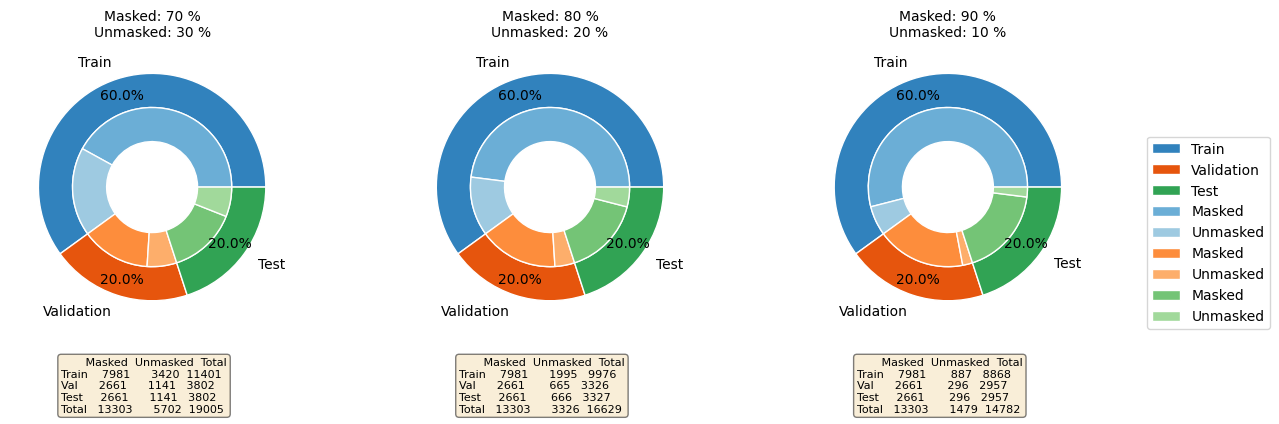

In [ ]:
output_dict_dir = '/jsons/'
output_file_name = f'output_{db}_'
output_file_extension = '.json'

create_graphs(interim_data_dir + output_dict_dir, output_file_name, output_file_extension, filename_proportion, assets_data_dir)